## How machine learning helps you forecast a possible heart disease
In this project, we will compare 3 machine learning models, namely <span style='color:red;background-color:#ffff5e'> XGBoost </span>, <span style='color:red;background-color:#ffff5e'>K-nearest neighbors </span> and <span style='color:red;background-color:#ffff5e'>Random Forest </span>.The dataset used for this project is called [`heart-disease-uci`](https://www.kaggle.com/ronitf/heart-disease-uci/data)

**STEP 1: Import required libraries and dataset**  
We need to import 
- pandas: to import data in `Dataframe`
- scikit-learn:  to utilise `K-nearest neighbors` and `Random Forest`
- xgboost: to utilise `Extreme Gradient Boosting` 
- seaborn: to visualise `correlation matrix`

In [26]:
import pandas as pd
import os, sys
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import seaborn as sns
from IPython.display import display, HTML

#Code to center the output
display(HTML("""
<style>
.output {
    display: flex;
    align-items: center;
    text-align: center;
}
</style>
"""))

In [27]:
df = pd.read_csv(r'C:\Users\Admin PC\Desktop\BDS\Data Structures & Algorithm\heart.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


<center><span style='font-style:italic'> Data exploration </span></center>

**STEP 2: Data exploration & Visualisation**  
Let's see what information we can obtain from the given dataset before jumping into modelling in order that our predictive model will perform at its best.

In [28]:
df.loc[:, df.columns != 'target'].describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000


<center><span style='font-style:italic'> Statistics about the dataset </span></center>

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
age         303 non-null int64
sex         303 non-null int64
cp          303 non-null int64
trestbps    303 non-null int64
chol        303 non-null int64
fbs         303 non-null int64
restecg     303 non-null int64
thalach     303 non-null int64
exang       303 non-null int64
oldpeak     303 non-null float64
slope       303 non-null int64
ca          303 non-null int64
thal        303 non-null int64
target      303 non-null int64
dtypes: float64(1), int64(13)
memory usage: 33.2 KB


<center><span style='font-style:italic'> Check for null-values </span></center>

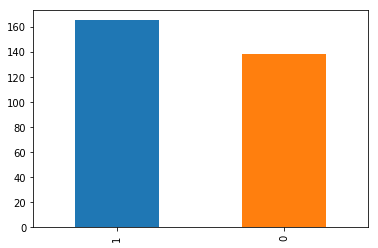

In [30]:
df['target'].value_counts().plot.bar()

<center><span style='font-style:italic'> Check data balance </span></center>

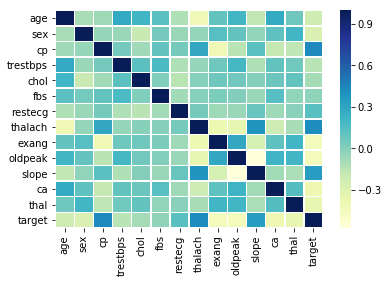

In [31]:
cm = sns.heatmap(df.corr(), linewidths = .5, cmap="YlGnBu")

<center><span style='font-style:italic'> Correlation matrix </span></center>

This correlation matrix gives information about the correlation between each variable of the dataset. The darker the color is, the more correlated the variables are.
For example, we are aiming at predicting the target, and there 3 variables that are highly correlated which called `cp`, `thalach` and `slope`.

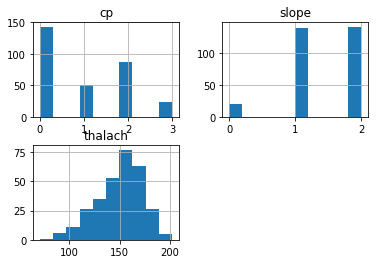

In [32]:
hist = df[['cp', 'thalach', 'slope']].hist()

**STEP 3: Data preparation**  
We will split our dataset into `train` and `test` sets, each set will consists of input `features` and corresponding `labels`

In [33]:
features = df.loc[:, df.columns != 'target'].values[:,:13]
print(features)

[[63.  1.  3. ...  0.  0.  1.]
 [37.  1.  2. ...  0.  0.  2.]
 [41.  0.  1. ...  2.  0.  2.]
 ...
 [68.  1.  0. ...  1.  2.  3.]
 [57.  1.  0. ...  1.  1.  3.]
 [57.  0.  1. ...  1.  1.  2.]]


<center><span style='font-style:italic'> Input features or Attributes </span></center>

In [34]:
label = df.loc[:, 'target'].values
print(label)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0]


<center><span style='font-style:italic'> Ground-truth or Labels or Target variables </span></center>

Initialize a MinMaxScaler and scale the features to between -1 and 1 to `normalize them`. The `MinMaxScaler` transforms features by scaling them to a given range. The `fit_transform()` method fits to the data and then transforms it. We don’t need to scale the labels.

In [35]:
scaler = MinMaxScaler((-1,1))
x = scaler.fit_transform(features)
y = label
print(x)

[[ 0.41666667  1.          1.         ... -1.         -1.
  -0.33333333]
 [-0.66666667  1.          0.33333333 ... -1.         -1.
   0.33333333]
 [-0.5        -1.         -0.33333333 ...  1.         -1.
   0.33333333]
 ...
 [ 0.625       1.         -1.         ...  0.          0.
   1.        ]
 [ 0.16666667  1.         -1.         ...  0.         -0.5
   1.        ]
 [ 0.16666667 -1.         -0.33333333 ...  0.         -0.5
   0.33333333]]


Now, `split` the dataset into `training` and `testing` sets keeping 20% of the data for testing.

In [36]:
x_train,x_test,y_train,y_test=train_test_split(x, y, test_size=0.2, random_state=5)

**STEP 4: Train the model**

In this step, I will use three algorithms to train our model, namely:
1. XGB Classifier
2. K-nearest neighbors
3. Random forest classifier

***1. XGB Classifier***

Initialize an `XGBClassifier` and train the model. This classifies using `eXtreme Gradient Boosting`- using gradient boosting algorithms for modern data science problems. It falls under the category of `Ensemble Learning` in ML, where we `train` and `predict` using many models to produce one superior output.

In [37]:
model=XGBClassifier()
model.fit(x_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

Finally, generate `y_pred` (predicted values for x_test) and calculate the accuracy for the model. Print it out.

In [38]:
y_pred=model.predict(x_test)
print(accuracy_score(y_test, y_pred)*100)

85.24590163934425


<center><span style='font-style:italic'> XGB algorithm gives us an accuracy of approx. 85% </span></center>

***2. K-Nearest Neighbors***

Next, I'm gonna use `KNN algorithm` to train the model. This classifier looks for the classes of `K nearest neighbors` of a given data point and based on the majority class, it assigns a class to this data point. However, the number of neighbors can be varied. I varied them from 1 to 10 neighbors and calculated the test score in each case.

In [39]:
knn_scores = []
for k in range(1,11):
    knn_classifier = KNeighborsClassifier(n_neighbors = k)
    knn_classifier.fit(x_train, y_train)
    knn_scores.append(knn_classifier.score(x_test, y_test))

<center>Then, I plot a line graph of the number of neighbors and the test score achieved in each case.</center>

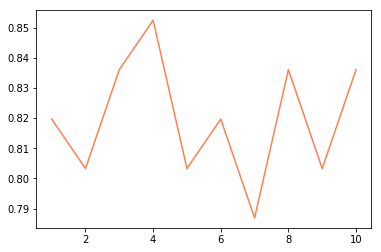

In [40]:
knn = sns.lineplot(x = [i for i in range(1,11)], y = knn_scores, color = 'coral')

As you can see, we achieved the maximum score of approx. `85%` when the number of neighbors was chosen to be 4.

***3. Random Forest Classifier***

Next, we will use `Random Forest Classifier` algorithm. It creates a forest of trees where each tree is formed by a random selection of features from the total features. Here, we can vary the number of trees that will be used to predict the class. I calculate test scores over 10, 100, 200, 500 and 1000 trees.

In [41]:
rf_scores = []
estimators = [10, 100, 200, 500, 1000]
for i in estimators:
    rf_classifier = RandomForestClassifier(n_estimators = i, random_state = 0)
    rf_classifier.fit(x_train, y_train)
    rf_scores.append(rf_classifier.score(x_test, y_test))

<center>Then, I will draw the bar plot to see the scores of different estimators.</center>

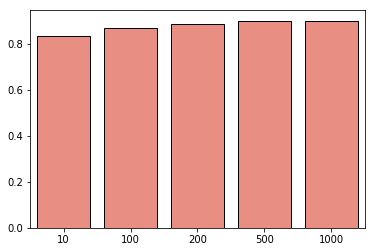

In [42]:
rf = sns.barplot(x = estimators, y = rf_scores, color = 'salmon', edgecolor = (0,0,0), linewidth = 1)

Looking at the bar graph, we can see that the maximum score of `90%` was achieved for both 500 and 1000 trees.

# Summary
In this project, we've learned to analyse the heart disease dataset using various factors. We also trained and tested 3 models and the maximum accuracy is as followed:
1. XGB Classifier: `85%`
2. K-Nearesr Neighbors: `85%`
3. Random Forest Classifier: `90%`

The `Random Forest Classifier` gives us the best score with an accuracy of `90%`

## Hope you enjoy this project